In [7]:
# generic imports
import torch
torch.set_grad_enabled(False)

# Utilities
from general_utils import (
  ModelAndTokenizer,
  make_inputs,
  decode_tokens,
)
from patchscopes_utils import *

In [2]:
# loading the model
model_to_hook = {
    "EleutherAI/pythia-12b": set_hs_patch_hooks_neox,
    "meta-llama/Llama-2-13b-chat-hf": set_hs_patch_hooks_llama,
    "./stable-vicuna-13b": set_hs_patch_hooks_llama,
    "EleutherAI/gpt-j-6b": set_hs_patch_hooks_gptj
}

CURRENT_LLM = "meta-llama/Llama-2-13b-chat-hf"

model_name = CURRENT_LLM

if "13b" in model_name or "12b" in model_name:
    torch_dtype = torch.float16
else:
    torch_dtype = None

my_device = torch.device("cuda:0")

mt = ModelAndTokenizer(
    model_name,
    low_cpu_mem_usage=False,
    torch_dtype=torch_dtype,
    device=my_device,
)

mt.set_hs_patch_hooks = model_to_hook[model_name]
mt.model.eval()

/home/galniv/patch_transformers/transformers-4.34.1/src/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/home/galniv/patch_transformers/transformers-4.34.1/src/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 5120)
    (layers): ModuleList(
      (0-39): 40 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=5120, out_features=5120, bias=False)
          (k_proj): Linear(in_features=5120, out_features=5120, bias=False)
          (v_proj): Linear(in_features=5120, out_features=5120, bias=False)
          (o_proj): Linear(in_features=5120, out_features=5120, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=5120, out_features=13824, bias=False)
          (up_proj): Linear(in_features=5120, out_features=13824, bias=False)
          (down_proj): Linear(in_features=13824, out_features=5120, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
  (lm_

In [3]:
def generate_and_extract_intermediate_values(prompt):
    """
    Running the model and generating intermediate representations in each layer for:
    1. residuals pre-mlp
    2. mlp outputs
    3. hidden states
    """
    store_hooks = []
    residual_pre_mlp_cache_ = []
    mlp_cache_ = []

    input_ids = make_inputs(mt.tokenizer, [prompt], device=mt.device)

    def store_mlp_hook(module, input, output):
        residual_pre_mlp_cache_.append(input[0][0])
        mlp_cache_.append(output[0])

    for layer in mt.model.model.layers:
        store_hooks.append(layer.mlp.register_forward_hook(store_mlp_hook))

    generated = mt.model(**input_ids, output_hidden_states=True)

    hs_cache_ = [
        generated["hidden_states"][layer + 1][0] for layer in range(mt.num_layers)
    ]

    remove_hooks(store_hooks)

    return residual_pre_mlp_cache_, mlp_cache_, hs_cache_

def patchscope_interpret(vec, target_layer=0):
    """Interpretation of vectors using Patchscopes technique."""
    target_prompt = "Syria: Country in the Middle East, Leonardo DiCaprio: American actor, Samsung: South Korean multinational major appliance and consumer electronics corporation, x"
    
    # last token within target prompt
    target_idx = -1

    patch_config = {
        target_layer: [(target_idx, vec)]
    }

    patch_hooks = mt.set_hs_patch_hooks(
        mt.model, patch_config, module="hs", patch_input=False, generation_mode=True,
    )

    inp = make_inputs(mt.tokenizer, [target_prompt], device=mt.device)

    seq_len = len(inp["input_ids"][0])
    max_token_to_produce = 10
    output_toks = mt.model.generate(
        inp["input_ids"],
        max_length=seq_len + max_token_to_produce,
        pad_token_id=mt.model.generation_config.eos_token_id,
    )
    
    remove_hooks(patch_hooks)

    generations_patched =  mt.tokenizer.decode(output_toks[0][len(inp["input_ids"][0]):])
    
    return generations_patched

def find_token_id(prompt, token):
    """finding the offset of a specific token within a prompt."""
    inp = make_inputs(mt.tokenizer, [prompt], device=mt.device)
    decoded = decode_tokens(mt.tokenizer, inp['input_ids'])[0]

    return decoded.index(token)

def find_last_token(prompt):
    """finding the offset of a specific token within a prompt."""
    inp = make_inputs(mt.tokenizer, [prompt], device=mt.device)
    decoded = decode_tokens(mt.tokenizer, inp['input_ids'])[0]

    return decoded[-1]



In [ ]:
import csv
test_pairs = [
    [x, find_last_token(x)] for x in ['Pink Floyd', 'Led Zeppelin', 'Arctic Monkeys', 'Daft Punk', 'Iron Maiden', 'Green Day', 'Pearl Jam', 'Maroon 5', 'Joy Division', 'Deep Purple', 'Depeche Mode', 'Black Sabbath', 'Judas Priest', 'Arcade Fire', 'Tame Impala', 'Pulp Fiction', 'Fight Club', 'Top Gun', 'King Kong', 'Mad Max', 'Die Hard', 'Mean Girls', 'Home Alone', 'Dirty Dancing', 'Black Panther', 'Kill Bill', 'Forrest Gump', 'Finding Nemo', 'Independence Day', 'Pitch Perfect', 'Shutter Island', 'The Shining', 'Reservoir Dogs', 'Star Wars', 'Baby Driver', 'American Psycho', 'Pretty Woman', 'Fatal Attraction', 'Black Swan', 'Taxi Driver', "Diana, Princess of Wales", "Back to the Future", "Alexander the Great", "Saturday Night Live", "Red Hot Chili Peppers", "Will Smith", "Titanic", "George Washington"]
]

headers = ["source prompt", "token", "layer", "amplification value", "result"]

saved_vals = open("superscopes_eval_patch_to_same_layer.csv", "w", newline="")
writer = csv.writer(saved_vals)
writer.writerow(headers)

for prompt, tok in test_pairs:
    residual_pre_mlp_cache, mlp_outputs_cache, hs_cache = generate_and_extract_intermediate_values(prompt)
    
    source_position = find_token_id(prompt, tok)

    for layer in range(1, 8):
        print(f"Layer {layer}")
        for amp in range(3, 18, 3):
            print()
            result = patchscope_interpret(mlp_outputs_cache[layer][source_position] * amp, target_layer=layer)
            print(f"MLP Output (Amp={amp}) result: {result}")
            writer.writerow([prompt, tok, layer, amp, result])
        print()
        print()
    saved_vals.flush()

In [ ]:
import csv
test_pairs = [
    [x, find_last_token(x)] for x in ['Pink Floyd', 'Led Zeppelin', 'Arctic Monkeys', 'Daft Punk', 'Iron Maiden', 'Green Day', 'Pearl Jam', 'Maroon 5', 'Joy Division', 'Deep Purple', 'Depeche Mode', 'Black Sabbath', 'Judas Priest', 'Arcade Fire', 'Tame Impala', 'Pulp Fiction', 'Fight Club', 'Top Gun', 'King Kong', 'Mad Max', 'Die Hard', 'Mean Girls', 'Home Alone', 'Dirty Dancing', 'Black Panther', 'Kill Bill', 'Forrest Gump', 'Finding Nemo', 'Independence Day', 'Pitch Perfect', 'Shutter Island', 'The Shining', 'Reservoir Dogs', 'Star Wars', 'Baby Driver', 'American Psycho', 'Pretty Woman', 'Fatal Attraction', 'Black Swan', 'Taxi Driver', "Diana, Princess of Wales", "Back to the Future", "Alexander the Great", "Saturday Night Live", "Red Hot Chili Peppers", "Will Smith", "Titanic", "George Washington"]
]

headers = ["source prompt", "token", "layer", "amplification value", "result"]

saved_vals = open("superscopes_eval_patchscopes_reference.csv", "w", newline="")
writer = csv.writer(saved_vals)
writer.writerow(headers)

amp = 1

for prompt, tok in test_pairs:
    residual_pre_mlp_cache, mlp_outputs_cache, hs_cache = generate_and_extract_intermediate_values(prompt)
    
    source_position = find_token_id(prompt, tok)


    for layer in range(1, 8):
        print(f"Layer {layer}")
        result = patchscope_interpret(mlp_outputs_cache[layer][source_position], target_layer=layer)
        print(f"MLP Output (Amp={amp}) result: {result}")
        writer.writerow([prompt, tok, layer, amp, result])
        print()
        print()
    saved_vals.flush()

In [50]:
import csv
import torch
from transformers import AutoTokenizer, AutoModel

best_scoring = {
}

already_seen = {
}

# Load the same underlying weights as "all-MiniLM-L6-v2"
MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)

y_values_1 = [0 for _ in range(1, 8)]  # First dataset (0-8 range)
y_values_2 = [0 for _ in range(1, 8)]

def mean_pooling(model_output, attention_mask):
    """
    Mean Pooling - Take attention mask into account for correct averaging
    """
    # Extract the last hidden state
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    
    # Sum the token embeddings up and divide by the sum of attention mask
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    
    return sum_embeddings / sum_mask

amp = 1

with open('superscopes_eval_patchscopes_reference.csv', 'r', encoding='utf-8') as file:
    reader = csv.DictReader(file)
    for row in reader:
        source_prompt = row["source prompt"]
        token = row["token"]
        layer = row["layer"]
        result = row["result"]
        amplification_value = row["amplification value"]

        # 1) Tokenize inputs
        encoded_input = tokenizer([source_prompt, result],
                                  padding=True,
                                  truncation=True,
                                  return_tensors='pt')
        
        # 2) Pass through model
        with torch.no_grad():
            model_output = model(**encoded_input)
        
        # 3) Pooling
        sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
        
        # 4) Normalize embeddings (to get cosine similarity via dot product)
        sentence_embeddings = torch.nn.functional.normalize(sentence_embeddings, p=2, dim=1)
        
        # 5) Compute cosine similarity (dot product of normalized vectors)
        score = torch.matmul(sentence_embeddings[0], sentence_embeddings[1]).item()

        best_scoring[(source_prompt, layer)] = [amp, result, score]
        if score > 0.3:
            try:
                if already_seen[(source_prompt, layer)] == 1:
                    continue
            except KeyError:
                pass
            y_values_1[int(layer) - 1] += 1
            already_seen[(source_prompt, layer)] = 1


In [51]:
already_seen = {
}

with open('superscopes_eval_patch_to_same_layer.csv', 'r', encoding='utf-8') as file:
    reader = csv.DictReader(file)
    for row in reader:
        source_prompt = row["source prompt"]
        token = row["token"]
        layer = row["layer"]
        result = row["result"]
        amplification_value = row["amplification value"]

        # 1) Tokenize inputs
        encoded_input = tokenizer([source_prompt, result],
                                  padding=True,
                                  truncation=True,
                                  return_tensors='pt')
        
        # 2) Pass through model
        with torch.no_grad():
            model_output = model(**encoded_input)
        
        # 3) Pooling
        sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
        
        # 4) Normalize embeddings (to get cosine similarity via dot product)
        sentence_embeddings = torch.nn.functional.normalize(sentence_embeddings, p=2, dim=1)
        
        # 5) Compute cosine similarity (dot product of normalized vectors)
        score = torch.matmul(sentence_embeddings[0], sentence_embeddings[1]).item()

        best_to_test = best_scoring[(source_prompt, layer)][2] if best_scoring[(source_prompt, layer)][2] > 0 else 0

        if score > 0.3:
            try:
                if already_seen[(source_prompt, layer)] == 1:
                    continue
            except KeyError:
                pass
            y_values_2[int(layer) - 1] += 1
            already_seen[(source_prompt, layer)] = 1


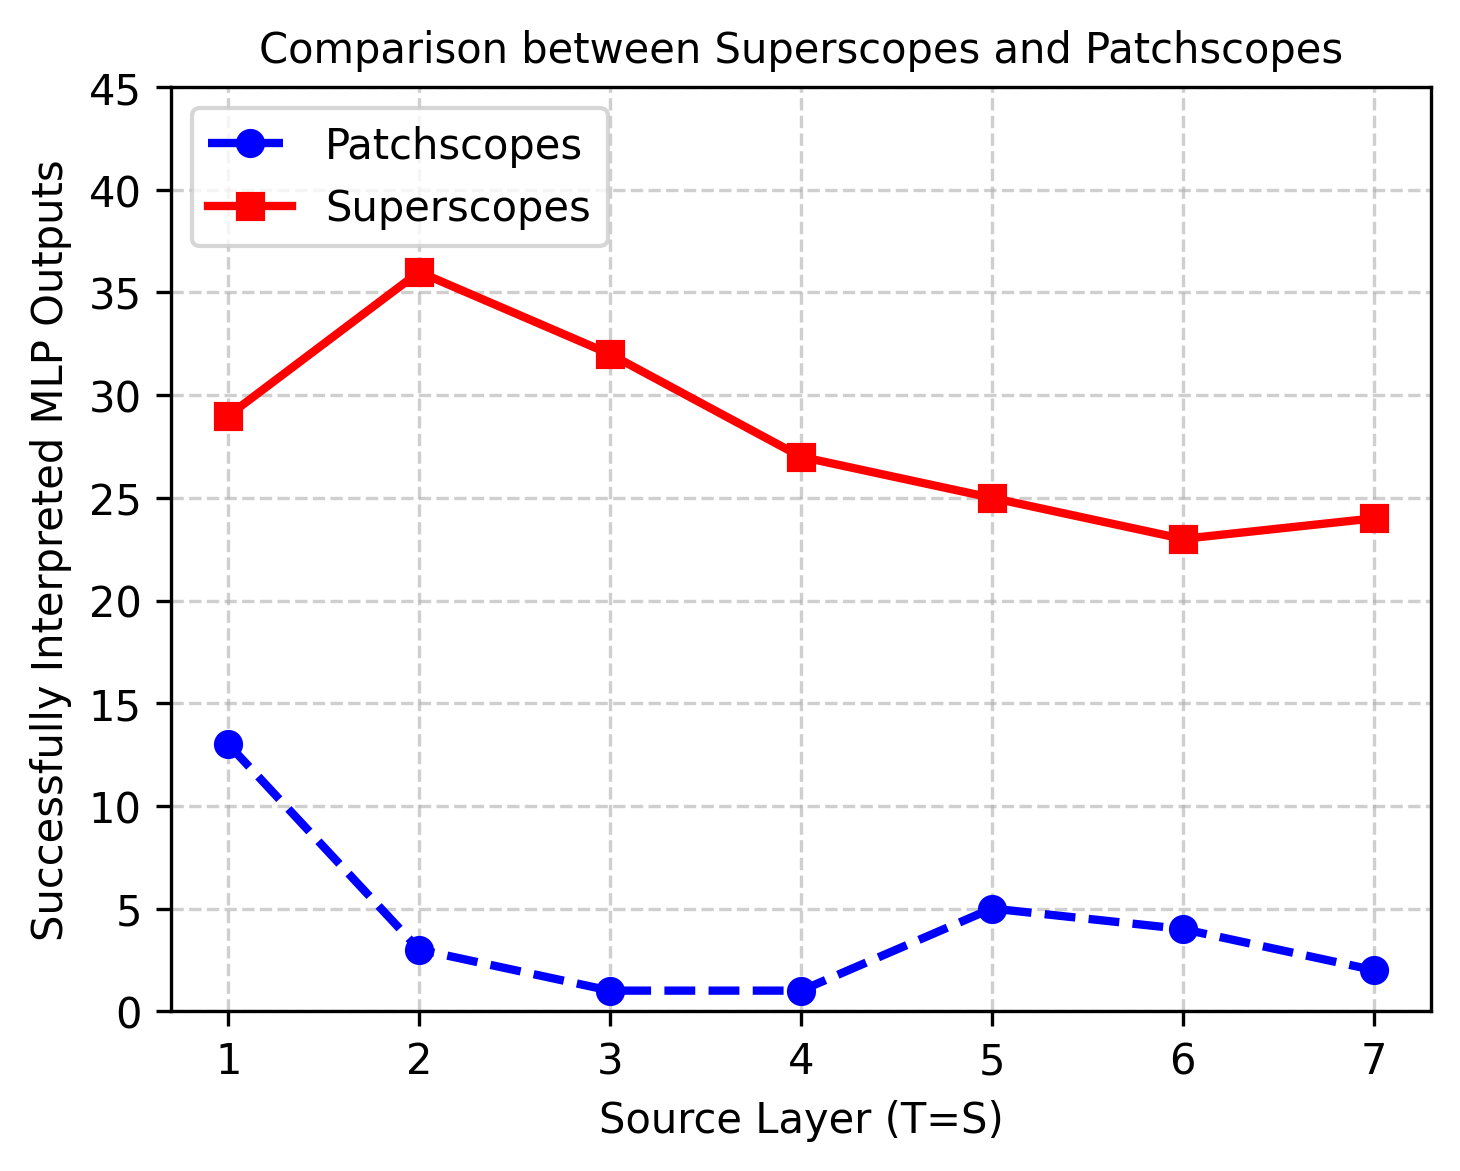

In [54]:
import matplotlib.pyplot as plt

x_values = [1, 2, 3, 4, 5, 6, 7]  # X-axis values (1-7)

# Create figure with proper proportions
plt.figure(figsize=(6, 4), dpi=300)  # High resolution

# Plot first line
plt.plot(x_values, y_values_1, marker='o', linestyle='--', linewidth=2, markersize=6, color='blue', label="Patchscopes")

# Plot second line
plt.plot(x_values, y_values_2, marker='s', linestyle='-', linewidth=2, markersize=6, color='red', label="Superscopes")

plt.subplots_adjust(left=0.3, right=1.0)  # Increase 'left' to push the plot right

# Axis labels and title
plt.xlabel("Source Layer (T=S)", fontsize=10)
plt.ylabel("Successfully Interpreted MLP Outputs", fontsize=10)
plt.title("Comparison between Superscopes and Patchscopes", fontsize=10)

# Set Y-axis limits to be proportional (since values are between 0-8)
plt.ylim(0, 45)

# Grid & legend
plt.grid(True, linestyle="--", alpha=0.6)  # Light grid for readability
plt.legend(fontsize=10, loc="upper left")

# Save as high-quality image (PDF, PNG, etc.)
plt.savefig("BarFigure.pdf", bbox_inches='tight')  # Save as PDF for academic use
plt.savefig("BarFigure.png", dpi=300, bbox_inches='tight')  # Save as PNG for presentations

# Show the plot
plt.show()

save = (y_values_1, y_values_2)
